# 随机梯度下降

在很多深度学习场景中，我们在训练过程中使用随机梯度下降，但没有解释它为什么起作用。本节继续更详细地说明*随机梯度下降*（stochastic gradient descent）。


In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

## 随机梯度更新

在深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值。给定$n$个样本的训练数据集，我们假设$f_i(\mathbf{x})$是关于索引$i$的训练样本的损失函数，其中$\mathbf{x}$是参数向量。然后我们得到目标函数 $f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x})$。$\mathbf{x}$的目标函数的梯度计算为 $\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x})$。

如果使用梯度下降法，则每个自变量迭代的计算代价为$\mathcal{O}(n)$，它随$n$线性增长。因此，当训练数据集较大时，每次迭代的梯度下降计算代价将较高。随机梯度下降（SGD）可降低每次迭代时的计算代价。在随机梯度下降的每次迭代中，我们对数据样本随机均匀采样一个索引$i$，其中$i\in\{1,\ldots, n\}$，并计算梯度$\nabla f_i(\mathbf{x})$以更新$\mathbf{x}$：$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x})$，其中$\eta$是学习率。

我们可以看到，每次迭代的计算代价从梯度下降的$\mathcal{O}(n)$降至常数$\mathcal{O}(1)$。此外，我们要强调，随机梯度$\nabla f_i(\mathbf{x})$是对完整梯度$\nabla f(\mathbf{x})$的无偏估计，因为 $\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x})$。这意味着，平均而言，随机梯度是对梯度的良好估计。

现在，我们将把它与梯度下降进行比较，方法是向梯度添加均值为0、方差为1的随机噪声，以模拟随机梯度下降。

In [2]:
def f(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # 目标函数的梯度
    return 2 * x1, 4 * x2

In [3]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: -0.088981, x2: -0.050242


/Users/ruan/workspace/ai/venv/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/ruan/workspace/ai/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


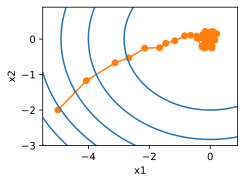

In [4]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # 常数学习速度
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

正如我们所看到的，随机梯度下降中变量的轨迹比我们在之前 GD 中观察到的梯度下降中观察到的轨迹嘈杂得多。这是由于梯度的随机性质。也就是说，即使我们接近最小值，我们仍然受到通过$\eta \nabla f_i(\mathbf{x})$的瞬间梯度所注入的不确定性的影响。即使经过50次迭代，质量仍然不那么好。更糟糕的是，经过额外的步骤，它不会得到改善。这给我们留下了唯一的选择：改变学习率$\eta$。但是，如果我们选择的学习率太小，我们一开始就不会取得任何有意义的进展。另一方面，如果我们选择的学习率太大，我们将无法获得一个好的解决方案，如上所示。解决这些相互冲突的目标的唯一方法是在优化过程中*动态*降低学习率。

这也是在`sgd`步长函数中添加学习率函数`lr`的原因。在上面的示例中，学习率调度的任何功能都处于休眠状态，因为我们将相关的`lr`函数设置为常量。

## 动态学习率

用与时间相关的学习率$\eta(t)$取代$\eta$增加了控制优化算法收敛的复杂性。特别是，我们需要弄清$\eta$的衰减速度。如果太快，我们将过早停止优化。如果减少的太慢，我们会在优化上浪费太多时间。以下是随着时间推移调整$\eta$时使用的一些基本策略（稍后我们将讨论更高级的策略）：

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{分段常数} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{指数衰减} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{多项式衰减}
\end{aligned}
$$

在第一个*分段常数*（piecewise constant）场景中，我们会降低学习率，例如，每当优化进度停顿时。这是训练深度网络的常见策略。或者，我们可以通过*指数衰减*（exponential decay）来更积极地减低它。不幸的是，这往往会导致算法收敛之前过早停止。一个受欢迎的选择是$\alpha = 0.5$的*多项式衰减*（polynomial decay）。在凸优化的情况下，有许多证据表明这种速率表现良好。

让我们看看指数衰减在实践中是什么样子。


epoch 1000, x1: -0.712224, x2: -0.056727


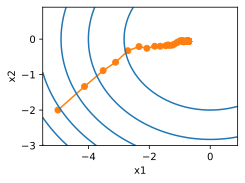

In [5]:
def exponential_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

正如预期的那样，参数的方差大大减少。但是，这是以未能收敛到最优解$\mathbf{x} = (0, 0)$为代价的。即使经过1000个迭代步骤，我们仍然离最优解很远。事实上，该算法根本无法收敛。另一方面，如果我们使用多项式衰减，其中学习率随迭代次数的平方根倒数衰减，那么仅在50次迭代之后，收敛就会更好。


epoch 50, x1: 0.031794, x2: 0.018504


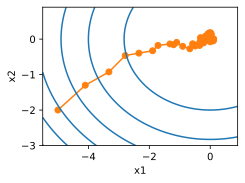

In [6]:
def polynomial_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

关于如何设置学习率，还有更多的选择。例如，我们可以从较小的学习率开始，然后使其迅速上涨，再让它降低，尽管这会更慢。我们甚至可以在较小和较大的学习率之间切换。现在，让我们专注于可以进行全面理论分析的学习率计划，即凸环境下的学习率。对一般的非凸问题，很难获得有意义的收敛保证，因为总的来说，最大限度地减少非线性非凸问题是NP困难的。

## 随机梯度和有限样本

到目前为止，在谈论随机梯度下降时，我们进行得有点快而松散。我们假设从分布$p(x, y)$中采样得到样本$x_i$（通常带有标签$y_i$），并且用它来以某种方式更新模型参数。特别是，对于有限的样本数量，我们仅仅讨论了由某些允许我们在其上执行随机梯度下降的函数$\delta_{x_i}$和$\delta_{y_i}$组成的离散分布$p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$。

但是，这不是我们真正做的。在本节的简单示例中，我们只是将噪声添加到其他非随机梯度上，也就是说，我们假装有成对的$(x_i, y_i)$。事实证明，这种做法在这里是合理的（有关详细讨论，请参阅练习）。更麻烦的是，在以前的所有讨论中，我们显然没有这样做。相反，我们遍历了所有实例*恰好一次*。要了解为什么这更可取，可以反向考虑一下，即我们*有替换地*从离散分布中采样$n$个观测值。随机选择一个元素$i$的概率是$1/n$。因此选择它*至少*一次就是$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-1/n)^n \approx 1-e^{-1} \approx 0.63$。

类似的推理表明，挑选一些样本（即训练示例）*恰好一次*的概率是 ${n \choose 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \left(1-\frac{1}{n}\right)^{n} \approx e^{-1} \approx 0.37$。

这导致与*无替换*采样相比，方差增加并且数据效率降低。因此，在实践中我们执行后者（这是本书中的默认选择）。最后一点注意，重复采用训练数据集的时候，会以*不同的*随机顺序遍历它。